# Experiments
This notebook contains some of the experiments that were performed for the Master Thesis


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import inseq
from datasets import load_from_disk, concatenate_datasets
from tatoeba import analysis as tatoeba_analysis
from rude_nmt import analysis as rude_nmt_analysis
from rude_nmt import label_korean
import pandas as pd


## Merge datasets
Due to the large amount of time needed to generate the translations, they are performed for each direction individually. Run the following merge in order to combine the two datasets into one for the remaining analyses if that has not already been done.

In [12]:
ko_data = load_from_disk("./data/tatoeba_de_ko_labelled")
de_data = load_from_disk("./data/tatoeba_ko_de_labelled")


In [13]:
ko_data = ko_data.rename_columns(
    {"bleu": "bleu_ko", "chrf": "chrf_ko", "comet": "comet_ko"}
)
de_data = de_data.rename_columns(
    {"bleu": "bleu_de", "chrf": "chrf_de", "comet": "comet_de"}
)


In [15]:
remove_cols = [col for col in ko_data.column_names if col in de_data.column_names]
disjunct_de = de_data.remove_columns(column_names=remove_cols)
merged_data = concatenate_datasets([ko_data, disjunct_de], axis=1)


In [16]:
# filter out a few sentences with translation errors
merged_data = merged_data.filter(
    lambda ex: len(ex["ko_nmt"].split()) > 0, num_proc=os.cpu_count()
)


Filter (num_proc=10):   0%|          | 0/996350 [00:00<?, ? examples/s]

In [17]:
merged_data.save_to_disk("./data/tatoeba_merged")


Saving the dataset (0/4 shards):   0%|          | 0/996270 [00:00<?, ? examples/s]

## Explore Dataset
First the dataset is explored to obtain some base level statistics

In [2]:
ds = load_from_disk("./data/tatoeba_merged")


In [3]:
print(ds)


Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt', 'de_formality_map_nmt'],
    num_rows: 996270
})


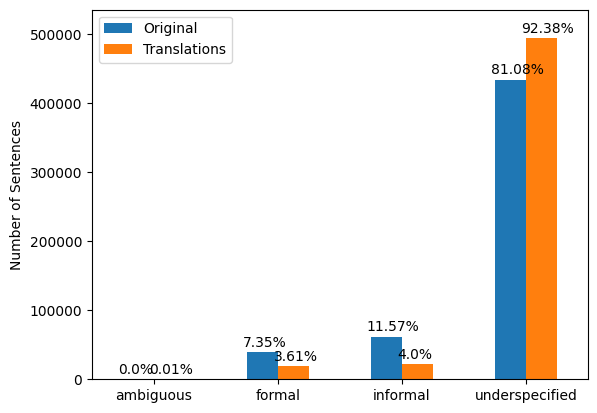

In [19]:
# get the German formalities
tatoeba_analysis.get_formality_plot(
    ds,
    ["de_formality", "de_formality_nmt"],
    plt_name="de_formality_merged_filtered",
    col_titles=["Original", "Translations"],
    horizontal_x=True,
)


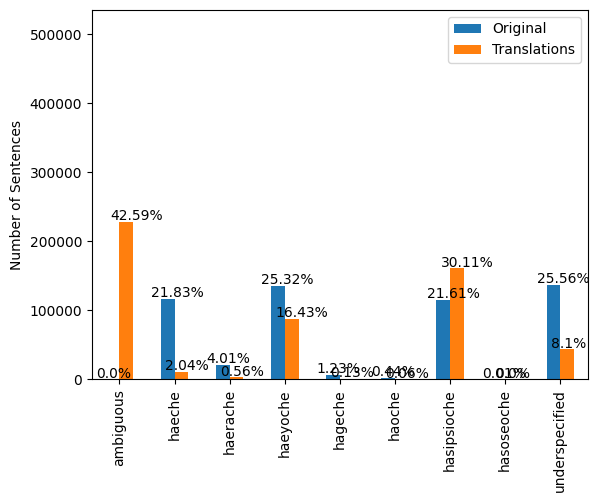

In [16]:
# get the Korean formalities
tatoeba_analysis.get_formality_plot(
    ds,
    ["ko_formality", "ko_formality_nmt"],
    plt_name="ko_formality_merged_filtered",
    col_titles=["Original", "Translations"],
    ax_annotate_vals=(0.3, 2500),
)


In [17]:
# get the German formality accuracy
print(
    rude_nmt_analysis.get_classification_report(
        ds, "de_formality", "de_formality_nmt", output_dict=False
    )
)


                precision    recall  f1-score   support

     ambiguous       0.00      0.00      0.00         0
        formal       0.29      0.14      0.19     39328
      informal       0.54      0.19      0.28     61907
underspecified       0.85      0.96      0.90    433967

      accuracy                           0.81    535202
     macro avg       0.42      0.32      0.34    535202
  weighted avg       0.77      0.81      0.78    535202



In [18]:
# get the Korean formality accuracy
print(
    rude_nmt_analysis.get_classification_report(
        ds, "ko_formality", "ko_formality_nmt", output_dict=False
    )
)


                precision    recall  f1-score   support

     ambiguous       0.00      0.00      0.00         0
        haeche       0.25      0.02      0.04    116821
      haerache       0.09      0.01      0.02     21438
      haeyoche       0.30      0.19      0.24    135522
       hageche       0.04      0.00      0.01      6585
        haoche       0.00      0.00      0.00      2329
   hasipsioche       0.27      0.38      0.32    115671
    hasoseoche       0.00      0.00      0.00        35
underspecified       0.57      0.18      0.27    136801

      accuracy                           0.18    535202
     macro avg       0.17      0.09      0.10    535202
  weighted avg       0.34      0.18      0.21    535202



In [30]:
# placeholder function for more specific analyses on parts of the dataset
sample_ds = ds.filter(
    lambda ex: ex["ko_formality_nmt"] == "underspecified", num_proc=os.cpu_count()
)


Filter (num_proc=10):   0%|          | 0/996270 [00:00<?, ? examples/s]

In [37]:
print(sample_ds)


Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt', 'de_formality_map_nmt'],
    num_rows: 305277
})


In [30]:
off_target_ds = ds.filter(
    lambda ex: not label_korean.is_korean_sent(ex["ws_tokens_ko_nmt"], 0.3),
    num_proc=os.cpu_count(),
    load_from_cache_file=False,
)


Filter (num_proc=10):   0%|          | 0/725864 [00:00<?, ? examples/s]

In [31]:
print(off_target_ds)


Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt'],
    num_rows: 160526
})


In [20]:
cross_ds = ds.filter(
    lambda ex: ex["de_formality_nmt"] != "ambiguous"
    and ex["de_formality"] != "ambiguous",
    num_proc=os.cpu_count(),
)


Filter (num_proc=10):   0%|          | 0/535202 [00:00<?, ? examples/s]

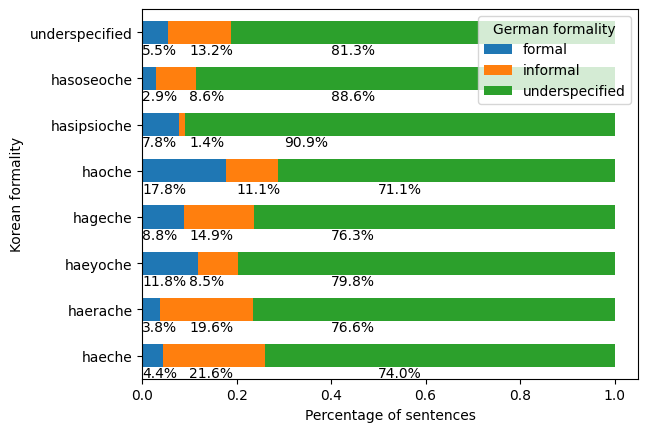

In [21]:
tatoeba_analysis.get_cross_formality_plot(
    cross_ds,
    "ko_formality",
    "de_formality",
    form_col_desc="Korean formality",
    cross_col_desc="German formality",
    plot_title="form_distribution_filtered_ds",
)


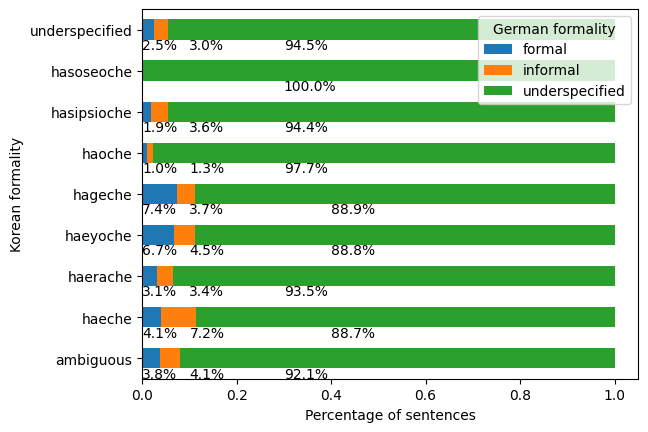

In [22]:
tatoeba_analysis.get_cross_formality_plot(
    cross_ds,
    "ko_formality_nmt",
    "de_formality_nmt",
    form_col_desc="Korean formality",
    cross_col_desc="German formality",
    plot_title="form_distribution_nmt_filtered_ds",
)


In [30]:
df = ds.to_pandas()

df = df[["de_formality", "de_formality_nmt"]]
df = df.groupby(["de_formality", "de_formality_nmt"], as_index=False).size()
df["de_formality"] = df["de_formality"].astype(
    pd.CategoricalDtype(
        [
            "formal",
            "informal",
            "underspecified",
            "ambiguous",
        ],
        ordered=True,
    )
)
df["de_formality_nmt"] = df["de_formality_nmt"].astype(
    pd.CategoricalDtype(
        [
            "formal",
            "informal",
            "underspecified",
            "ambiguous",
        ],
        ordered=True,
    )
)
df = df.sort_values(by=["de_formality", "de_formality_nmt"])


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 5 to 0
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   de_formality      16 non-null     category
 1   de_formality_nmt  16 non-null     category
 2   size              16 non-null     int64   
dtypes: category(2), int64(1)
memory usage: 696.0 bytes


In [32]:
df.to_csv("sankey_de.csv")

In [41]:
rude_nmt_analysis.plot_sankey(
    ds, "ko_formality", "ko_formality_nmt", "ko", show=True, plt_name="sankey_ko_formality"
)


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Sankey]
[d3blocks] >INFO> Create directory: [/var/folders/0q/82q5sw8x1mx2jz987fz_sdq40000gn/T/d3blocks]
[d3blocks] >INFO> filepath is set to [/var/folders/0q/82q5sw8x1mx2jz987fz_sdq40000gn/T/d3blocks/sankey.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Sankey]
[d3blocks] >INFO> filepath is set to [/Users/lsickert/Repositories/rude-nmt/sankey_ko_formality.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/Users/lsickert/Repositories/rude-nmt/sankey_ko_formality.html]
[d3blocks] >INFO> File not found: [file:////Users/lsickert/Repositories/rude-nmt/sankey_ko_formality.html]
[d3blocks] >INFO> Open browser: file:////Users/lsickert/Repositories/rude-nmt/sankey_ko_formality.html


In [42]:
rude_nmt_analysis.plot_sankey(
    ds, "de_formality", "de_formality_nmt", "de", show=True, plt_name="sankey_de_formality"
)


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Sankey]
[d3blocks] >INFO> filepath is set to [/var/folders/0q/82q5sw8x1mx2jz987fz_sdq40000gn/T/d3blocks/sankey.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Sankey]
[d3blocks] >INFO> filepath is set to [/Users/lsickert/Repositories/rude-nmt/sankey_de_formality.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/Users/lsickert/Repositories/rude-nmt/sankey_de_formality.html]
[d3blocks] >INFO> File not found: [file:////Users/lsickert/Repositories/rude-nmt/sankey_de_formality.html]
[d3blocks] >INFO> Open browser: file:////Users/lsickert/Repositories/rude-nmt/sankey_de_formality.html


In [8]:
rude_nmt_analysis.get_cramers_v(
    ds,
    "de_formality_nmt",
    "ko_formality_nmt",
    exclude_vals=["ambiguous", "underspecified"],
)


0.20785546765515941

In [8]:
# the comet score has to be upscaled to fit into the same range as BLEU and chrF
def upscale_comet(example):
    example["comet_ko"] = example["comet_ko"] * 100
    example["comet_de"] = example["comet_de"] * 100
    return example


In [9]:
ds = ds.map(upscale_comet, num_proc=os.cpu_count())


Map (num_proc=10):   0%|          | 0/996270 [00:00<?, ? examples/s]

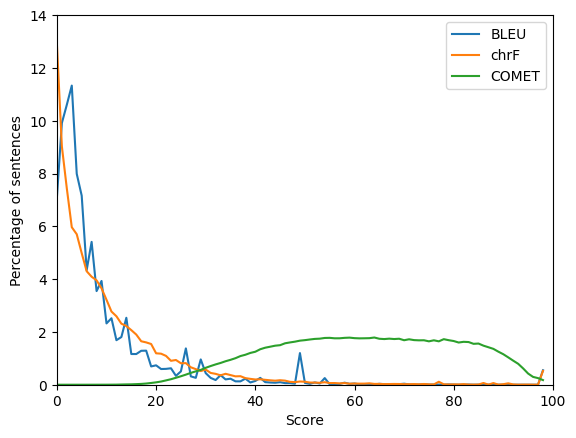

In [10]:
rude_nmt_analysis.plot_translation_metrics(
    ds,
    ["bleu_ko", "chrf_ko", "comet_ko"],
    ["BLEU", "chrF", "COMET"],
    show=True,
    plt_name="translation_metrics_ko",
)


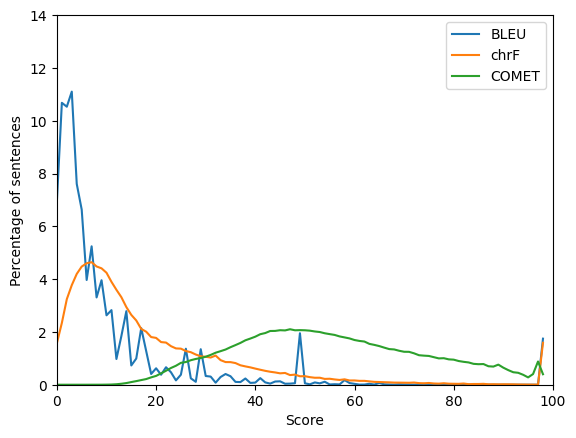

In [11]:
rude_nmt_analysis.plot_translation_metrics(
    ds,
    ["bleu_de", "chrf_de", "comet_de"],
    ["BLEU", "chrF", "COMET"],
    show=True,
    plt_name="translation_metrics_de",
)


In [26]:
from sacrebleu import corpus_bleu

corpus_bleu(ds["de_nmt"], [ds["source"]])


BLEU = 4.41 26.1/6.2/2.6/1.1 (BP = 0.945 ratio = 0.947 hyp_len = 10708797 ref_len = 11312750)

remove all ambiguous samples in case this has not been done during the labeling process

## Filter the data
As the next step, the different filters are applied to the dataset.
Run the analyses above again after each filtering step to obtain the statistics for the remaining samples.

First all sentences that are ambiguous in the source data are removed.

In [12]:
ds = ds.filter(
    lambda ex: not (
        ex["de_formality"] == "ambiguous" or ex["ko_formality"] == "ambiguous"
    ),
    num_proc=os.cpu_count(),
)
print(ds)


Filter (num_proc=10):   0%|          | 0/996270 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt', 'de_formality_map_nmt'],
    num_rows: 932651
})


remove all samples with a comet score below 0.4 (40 in this case, since the scores have been upscaled before)

In [13]:
ds = ds.filter(
    lambda ex: ex["comet_ko"] > 40 and ex["comet_de"] > 40, num_proc=os.cpu_count()
)
print(ds)


Filter (num_proc=10):   0%|          | 0/932651 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt', 'de_formality_map_nmt'],
    num_rows: 685841
})


remove all off-target Korean samples

In [14]:
ds = ds.filter(
    lambda ex: label_korean.is_korean_sent(ex["ws_tokens_ko_nmt"], 0.3),
    num_proc=os.cpu_count(),
)
print(ds)


Filter (num_proc=10):   0%|          | 0/685841 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt', 'de_formality_map_nmt'],
    num_rows: 535202
})


save filtered dataset to disk for use in the attributions

In [35]:
ds.save_to_disk("./data/tatoeba_filtered")


Saving the dataset (0/3 shards):   0%|          | 0/535376 [00:00<?, ? examples/s]

## Attributions
analyze the attributions for the translations

In [46]:
# optionally load the filtered dataset from disk
ds = load_from_disk("./data/tatoeba_filtered")


In [47]:
print(ds)


Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt', 'de_formality_map_nmt'],
    num_rows: 534572
})


In [10]:
attr_model = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "input_x_gradient",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "ko_KR"},
)


In [16]:
#    generated_texts=ds[0:10]["ko_nmt"],
#    layers=(0,-1),
#    heads=(0,-1),
out = attr_model.attribute(
    input_texts=ds[0]["source"],
    generated_texts=ds[0]["ko_nmt"],
    attribute_target=False,
    batch_size=5,
    step_scores=["probability"],
)
out = out.aggregate(
    aggregator=inseq.data.aggregator.AggregatorPipeline(
        [
            inseq.data.aggregator.SubwordAggregator,
            inseq.data.aggregator.SequenceAttributionAggregator,
        ]
    )
)
out.sequence_attributions[0].source_attributions[1:-1].T[1:-1].tolist()


Attributing with input_x_gradient...: 100%|██████████| 20/20 [00:11<00:00,  1.61it/s]


[[0.43840715289115906,
  0.04073164984583855,
  0.03927171230316162,
  0.17463932931423187,
  0.05206599459052086,
  0.036157362163066864,
  0.035129863768815994,
  0.04412499815225601,
  0.03491465747356415],
 [0.10082988440990448,
  0.10249965637922287,
  0.06634380668401718,
  0.40117913484573364,
  0.0718628540635109,
  0.05241023376584053,
  0.03628076612949371,
  0.04467998072504997,
  0.02951953560113907],
 [0.08911564201116562,
  0.06162300333380699,
  0.04919227212667465,
  0.42056745290756226,
  0.06929496675729752,
  0.04737542197108269,
  0.04316408932209015,
  0.047713398933410645,
  0.05252497270703316],
 [0.10068227350711823,
  0.07031651586294174,
  0.06434743851423264,
  0.19930046796798706,
  0.13165660202503204,
  0.0774613693356514,
  0.08638675510883331,
  0.10635272413492203,
  0.05673668161034584],
 [0.05263480916619301,
  0.02512262761592865,
  0.023653635755181313,
  0.0949077233672142,
  0.2626975476741791,
  0.16323798894882202,
  0.08677950501441956,
  0.125